## Imports / Helper Functions / Global Variables

In [1]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from shapely import get_coordinates, set_coordinates
from typing import List

In [2]:
# shorthand for datetime column

DATE_COL = 'Citation Issued DateTime'

In [25]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

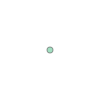

In [3]:
# helper functions for loading in US Census Bureau Geocoding data. This helps correct for ~10k observations with incorrect geolocation.

# 1ST -> 01ST, 2ND -> 02ND, etc., to be compatible
def inv_correct_numbered_streets(string):
    for i in range(1, 10):
        string = string.replace(f'{i}TH', f'0{i}TH')
    # 1st, 2nd and 3rd are special cases
    string = string.replace('1ST', '01ST')
    string = string.replace('2ND', '02ND')
    string = string.replace('3RD', '03RD')
    return string

def coord_string_to_point(coord_string):
    x, y = [float(string) for string in coord_string.split(',')]
    return Point(x, y)

coord_string_to_point("-122.46164710599999,37.77421091000008")

In [ ]:
# TODO: correct all "lock Of" addresses.

# feat_df[feat_df.street_id.str.contains('lock Of')]

In [5]:
def load_geocoder_data(csv_path='../data/chinook_ct_correct.csv'):
    geo = pd.read_csv(csv_path, header=None)
    geo = geo[geo[2] == 'Match']
    geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
    geo = geo[[1, 5]]
    geo.columns = ['street', 'geom']
    geo.street = geo.street.apply(inv_correct_numbered_streets)
    geo.geom = geo.geom.apply(coord_string_to_point)
    return geo

## Load Data and Fix Incorrect Data

In [7]:
geo_df = load_geocoder_data()
geo_df.head()

,street,geom
0,785 04TH AVE,POINT (-122.46164710599999 37.77421091000008)
1,756 08TH AVE,POINT (-122.46593421399996 37.77422294300004)
2,277 05TH AVE,POINT (-122.46339279499995 37.783491569000034)
3,404 08TH AVE,POINT (-122.46639889099998 37.78064289800005)
4,398 05TH ST,POINT (-122.40188964199996 37.77906450900008)


In [13]:
# create dictionary from pandas dataframe. 

geo_dict = pd.Series(geo_df.geom.values,index=geo_df.street).to_dict()

In [10]:
geo_df.shape

(2500, 2)

In [19]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,04/20/2022 12:10:00 PM,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,06/17/2022 04:12:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,04/23/2022 03:13:00 PM,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,02/22/2022 11:54:00 AM,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,02/17/2022 01:39:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [20]:
df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [21]:
# TODO: rewrite this using np.where or pandas where 
# TODO: use a better geocoder to fix more rows.

def fix_geom(row):
    if row['Citation Location'] in geo_dict:
        return geo_dict[row['Citation Location']]
    return row['geom']

df['geom'] = df.apply(fix_geom, axis=1)

## Add / Modify Dataframe Columns

In [22]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

In [23]:
# add auxillary date attribute columns based on the datetime. 

df['citation_day'] = df[DATE_COL].dt.day_name()
df['citation_hour'] = df[DATE_COL].dt.hour
df['citation_date'] = df[DATE_COL].dt.date

In [24]:
has_location_string = df[~df['Citation Location'].isnull()]

## Spatial Join

In [26]:
# load dataframe of street segments

street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

In [29]:
# TODO: technically should project into a flat geometry in order to get more accurate distances  

unique_streets = street_df.drop_duplicates(subset='Line')
unique_streets = unique_streets[['Corridor', 'Limits', 'Line']]

# save copy of geom column because it will be destroyed by projection / join.
unique_streets['street_geom_3d'] = unique_streets['Line']
unique_streets['street_length'] = unique_streets.street_geom_3d.apply(lambda x: x.length)

In [39]:
joined = gpd.sjoin_nearest(df, unique_streets, distance_col='dist', how='left')
joined.shape

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(1063988, 19)

## Group and Cluster

In [44]:
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [50]:
feat_df = joined[['citation_date', 'street_id', DATE_COL, 'Citation Location', 'geom', 'citation_day', 'citation_hour', 'street_geom_3d']]

In [70]:
feat_df['time_bin'] = feat_df[DATE_COL].dt.floor("15min").dt.time.astype(str)

In [76]:
all_bins = sorted(feat_df['time_bin'].unique())

In [77]:
# keep each entry for a particular time bin on a particular date + street

feat_df = feat_df.drop_duplicates(['citation_date', 'street_id', 'time_bin'])
binned_grouped = feat_df.groupby(['street_id', 'citation_day'])['time_bin'].agg(' '.join)

In [83]:
from collections import Counter

bin_string = "09:15:00 05:45:00"
bin_counter = Counter(all_bins)
bin_counter.update(bin_string.split(' '))
bin_counter

Counter({'00:00:00': 1,
         '00:15:00': 1,
         '00:30:00': 1,
         '00:45:00': 1,
         '01:00:00': 1,
         '01:15:00': 1,
         '01:30:00': 1,
         '01:45:00': 1,
         '02:00:00': 1,
         '02:15:00': 1,
         '02:30:00': 1,
         '02:45:00': 1,
         '03:00:00': 1,
         '03:15:00': 1,
         '03:30:00': 1,
         '03:45:00': 1,
         '04:00:00': 1,
         '04:15:00': 1,
         '04:30:00': 1,
         '04:45:00': 1,
         '05:00:00': 1,
         '05:15:00': 1,
         '05:30:00': 1,
         '05:45:00': 2,
         '06:00:00': 1,
         '06:15:00': 1,
         '06:30:00': 1,
         '06:45:00': 1,
         '07:00:00': 1,
         '07:15:00': 1,
         '07:30:00': 1,
         '07:45:00': 1,
         '08:00:00': 1,
         '08:15:00': 1,
         '08:30:00': 1,
         '08:45:00': 1,
         '09:00:00': 1,
         '09:15:00': 2,
         '09:30:00': 1,
         '09:45:00': 1,
         '10:00:00': 1,
         '10:15:

In [84]:
def bin_string_to_counter(bin_string):
    bin_counter = Counter(all_bins)
    bin_counter.update(bin_string.split(' '))
    return bin_counter

binned_grouped.apply(bin_string_to_counter)

street_id                            citation_day
01st St Clementina St  -  Folsom St  Saturday        {'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...
                                     Thursday        {'00:00:00': 1, '00:15:00': 2, '00:30:00': 1, ...
                                     Tuesday         {'00:00:00': 1, '00:15:00': 2, '00:30:00': 1, ...
                                     Wednesday       {'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...
01st St Elim St  -  Mission St       Friday          {'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...
                                                                           ...                        
Zoe St Welsh St  -  Freelon St       Saturday        {'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...
                                     Sunday          {'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...
                                     Thursday        {'00:00:00': 1, '00:15:00': 12, '00:30:00': 9,...
                       

In [58]:
feat_df[feat_df.street_id.str.contains('lock Of')]

,citation_date,street_id,Citation Issued DateTime,Citation Location,geom,citation_day,citation_hour,street_geom_3d
1124,2022-01-17,Avenue B lock Of 701 - 749,2022-01-17 11:29:00,390 09TH AVE,POINT (-122.37162 37.82020),Monday,11,"LINESTRING (-122.37491 37.82317, -122.37504 37..."
1125,2022-02-05,Avenue B lock Of 701 - 749,2022-02-05 12:54:00,390 09TH AVE,POINT (-122.37162 37.82020),Saturday,12,"LINESTRING (-122.37491 37.82317, -122.37504 37..."
1126,2022-07-06,Avenue B lock Of 701 - 749,2022-07-06 11:24:00,390 09TH AVE,POINT (-122.37162 37.82020),Wednesday,11,"LINESTRING (-122.37491 37.82317, -122.37504 37..."
1127,2022-07-20,Avenue B lock Of 701 - 749,2022-07-20 10:40:00,390 09TH AVE,POINT (-122.37162 37.82020),Wednesday,10,"LINESTRING (-122.37491 37.82317, -122.37504 37..."
1128,2022-01-25,Avenue B lock Of 701 - 749,2022-01-25 09:10:00,390 09TH AVE,POINT (-122.37162 37.82020),Tuesday,9,"LINESTRING (-122.37491 37.82317, -122.37504 37..."
...,...,...,...,...,...,...,...,...
1059553,2022-11-07,Halibut Ct lock Of 1430 - 1434,2022-11-07 12:20:00,1314 05TH AVE,POINT (-122.37209 37.83127),Monday,12,"LINESTRING (-122.37559 37.82452, -122.37461 37..."
1059587,2022-11-07,Halibut Ct lock Of 1430 - 1434,2022-11-07 12:15:00,1386 05TH AVE,POINT (-122.37275 37.83207),Monday,12,"LINESTRING (-122.37559 37.82452, -122.37461 37..."
1059707,2022-09-21,Halibut Ct lock Of 1430 - 1434,2022-09-21 12:09:00,1358 06TH AVE,POINT (-122.37244 37.83177),Wednesday,12,"LINESTRING (-122.37559 37.82452, -122.37461 37..."
1059766,2022-11-07,Halibut Ct lock Of 1430 - 1434,2022-11-07 12:29:00,1287 04TH AVE,POINT (-122.37181 37.83102),Monday,12,"LINESTRING (-122.37559 37.82452, -122.37461 37..."


In [42]:
unique_streets[unique_streets.street_length > 0.01]

,Corridor,Limits,Line,street_geom_3d,street_length
215,Great Hwy,Lincoln Way - Sloat Blvd,"LINESTRING (-122.51034 37.76400, -122.51025 37...","LINESTRING (-122.51034 37.76400, -122.51025 37...",0.028796
377,Great Hwy,Lincoln Way - Sloat Blvd,"LINESTRING (-122.51034 37.76400, -122.51041 37...","LINESTRING (-122.51034 37.76400, -122.51041 37...",0.028797
607,Great Hwy,Sloat Blvd - Skyline Blvd,"LINESTRING (-122.50672 37.73547, -122.50666 37...","LINESTRING (-122.50672 37.73547, -122.50666 37...",0.012101
2474,Great Hwy,Sloat Blvd - Skyline Blvd,"LINESTRING (-122.50672 37.73547, -122.50682 37...","LINESTRING (-122.50672 37.73547, -122.50682 37...",0.012255
3218,John Muir Dr,Lake Merced Blvd - Skyline Blvd,"LINESTRING (-122.48572 37.70809, -122.48626 37...","LINESTRING (-122.48572 37.70809, -122.48626 37...",0.018843
14682,John F Shelley Dr,Cambridge St - Mansell St,"LINESTRING (-122.41648 37.72181, -122.41668 37...","LINESTRING (-122.41648 37.72181, -122.41668 37...",0.016105


In [40]:
# TODO: figure out how to resolve points that get mapped to multiple streets. for now, seems like only a small number have this problem so we ignore it.

has_multiple_citations = joined['Citation Number'].value_counts()
joined = joined[joined['Citation Number'].isin(has_multiple_citations[has_multiple_citations == 1].index)]


In [41]:
joined.shape

(1055954, 19)